In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import tensorflow as tf 

%matplotlib inline

# 1. Create Data for Toy Problem

Assume that at every 10th element there is a little extra added to the series
Question: Can an RNN fit this?


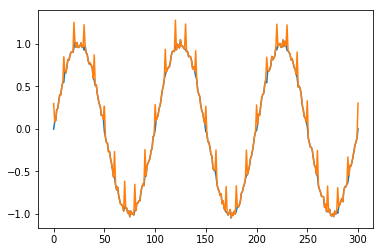

In [2]:
def sin(x, T=100):
    return np.sin(2.0 * np.pi * x/T)

def toy_problem(T=100, ampl=0.05):
    x = np.arange(0, 2*T + 1)
    noise = ampl*np.random.uniform(low = -1.0, high = 1.0, size=len(x))
    return sin(x) + noise

wx = 1
T = 150
f = toy_problem(T)
plt.plot(f)
f[0::10] = f[0::10] + 0.3
plt.plot(f)
print('Assume that at every 10th element there is a little extra added to the series')
print('Question: Can an RNN fit this?')

# Setup configuration dictionary


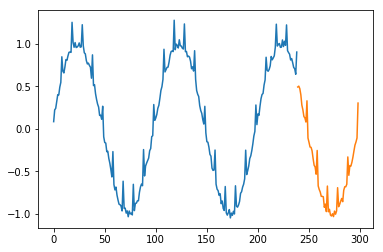

In [3]:
from scipy.linalg import hankel
# hankel matrix takes 'first colum' and 'last row' as arguments
#wx = 10
maxlen = 25
first_column = list(range(wx))
last_row = list(range(wx, f.shape[0]-1, 1))
t_pos = hankel(first_column, last_row)
X = f[t_pos]
Y = f[t_pos[-1,:]+1]

# Now arrange as a training and test set
N_train = int(X.shape[1]*0.8)
(X_train, Y_train) = (X[:, :N_train], Y[:N_train])
(X_test, Y_test)   = (X[:, (N_train - maxlen):], Y[N_train:])
plt.plot(Y_train)
plt.plot(list(range(Y.shape[0])[N_train:]), Y_test)

# Define Graph

In [4]:
n_in = 1
n_hidden = 20
n_out = 1
#maxlen = 25

tf.reset_default_graph()
# Input Parameters
#x = tf.placeholder(tf.float32, shape=[None, maxlen])
#ybar = tf.placeholder(tf.float32, shape=[None])
x = tf.placeholder(tf.float32, shape=[wx, maxlen])
ybar = tf.placeholder(tf.float32, shape=[maxlen])


# TF Variables
#y = inference(x, n_batch, maxlen=maxlen, n_hidden=n_hidden, n_out= n_out)
#loss = loss(y, t)
#train_step = training(loss)
def tfM(shape, name):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.01), name=name)

def tfB(shape, name):
    return tf.Variable(tf.zeros(shape), dtype=tf.float32, name=name)
    
def tfB_forget(shape, name):
    return tf.Variable(tf.ones(shape), dtype=tf.float32, name=name)

V = tfM([n_hidden], 'V')
c = tfB([n_out], 'b') 
# INPUT GATE

cell = tf.contrib.rnn.LSTMCell(n_hidden, forget_bias=1.0, use_peepholes=True)
initial_state = cell.zero_state(1, tf.float32)

s_i = initial_state
hlist = []

def tfrs(x):
    return tf.reduce_sum(x, axis=1)

hlist = []
for i in range(maxlen):
    (h_i, s_i) = cell(tf.expand_dims(x[:, i], 0) , s_i)
    hlist.append(h_i)

y = tf.convert_to_tensor([tf.reduce_sum(V*h) + c for h in hlist], 
                         dtype=tf.float32)
ylast = y[-1]
ybarlast = ybar[-1]
mse = tf.reduce_mean(tf.square(y[-1] - ybar[-1]))
ylast = y[]

#optimize = tf.train.GradientDescentOptimizer(learning_rate = 0.001)
optimize = tf.train.GradientDescentOptimizer(learning_rate = 0.02)
train_step = optimize.minimize(mse)
grads_and_vars = optimize.compute_gradients(mse, tf.trainable_variables())

In [98]:
tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)

[<tf.Variable 'V:0' shape=(20,) dtype=float32_ref>,
 <tf.Variable 'b:0' shape=(1,) dtype=float32_ref>,
 <tf.Variable 'lstm_cell/kernel:0' shape=(21, 80) dtype=float32_ref>,
 <tf.Variable 'lstm_cell/bias:0' shape=(80,) dtype=float32_ref>,
 <tf.Variable 'lstm_cell/w_f_diag:0' shape=(20,) dtype=float32_ref>,
 <tf.Variable 'lstm_cell/w_i_diag:0' shape=(20,) dtype=float32_ref>,
 <tf.Variable 'lstm_cell/w_o_diag:0' shape=(20,) dtype=float32_ref>]

In [5]:
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)


# Train Model

In [49]:
epochs  = 10
y_model = []
y_input = []
for epoch in range(epochs):
    mselist = []
    for i in range(X_train.shape[1] - maxlen):
        train_dict = {x: X_train[:,i:(maxlen + i)],
                      ybar: Y_train[i:(maxlen + i)]}
        sess.run(train_step, feed_dict = train_dict)
        mselist.append(mse.eval(session=sess, feed_dict = train_dict))
    print(np.mean(mselist))

        

0.000916899
0.000912335
0.000914847
0.000918134
0.000916989
0.000915207
0.00091586
0.000917242
0.000917204
0.000916649


## Extract results - insample

0.00542924
0.00542923964528



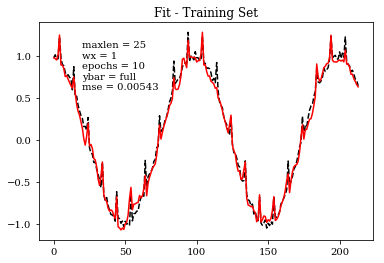

In [92]:
y_model = []
y_data  = []
mselist = []
max_i = list(range(X_train.shape[1] - maxlen))[-1]
for i in range(X_train.shape[1] - maxlen):
    train_dict = {x: X_train[:, i:(maxlen + i)], ybar: Y_train[i:(maxlen + i)]}
    y_i = sess.run(y, feed_dict = train_dict)
    mselist.append(mse.eval(session=sess, feed_dict=train_dict))
    y_model.append(y_i[-1])
    y_data.append(Y_train[maxlen + i -1])
y_model = np.concatenate(y_model)
print(np.mean(mselist))
print(np.mean(np.square(y_model - y_data)))

original = np.array(y_data)
y_ = y_model
plt.rc('font', family='serif')
plt.figure()
mse_train = np.mean(np.square(y_ - original))
#plt.plot(toy_problem(T, ampl=0), linestyle='dotted', color='#aaaaaa')
plt.plot(original, linestyle='dashed', color='black')
plt.plot(y_, color='red')
plt.text(20, 0.6, r'maxlen = ' + str(maxlen) + '\n' +\
               r'wx = ' + str(wx) + '\n' +\
               r'epochs = ' + str(epochs) + '\n' +\
               r'ybar = full' + '\n' + 
               r'mse = ' + "{0:.5f}".format(np.mean(mse_train))
               , fontsize=10)
plt.title('Fit - Training Set')
print()

# Extract results - out of sample

In [93]:
y_model = []
y_data  = []
mselist = []
max_i = list(range(X_test.shape[1] - maxlen))[-1]
for i in range(X_test.shape[1] - maxlen):
    test_dict = {x: X_test[:, i:(maxlen + i)]}
    y_i = sess.run(y, feed_dict = test_dict)
    #mselist.append(mse.eval(session=sess, feed_dict=test_dict))
    y_model.append(y_i[-1])
    #y_data.append(Y_test[maxlen + i -1])
y_model = np.concatenate(y_model)
print(np.mean(np.square(Y_test - y_model)))


0.0212389136146


# Plot results - out of sample

Text(20,0.6,'mse(test) = 0.02124')

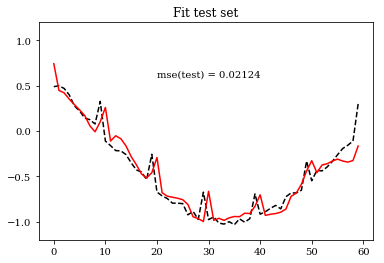

In [95]:
y_ = [y.eval(session=sess, feed_dict=
             {x: X_test[:,i:(maxlen + i)]})[-1]
      for i in range(X_test.shape[1] - maxlen)]
y_ = np.concatenate(y_)
#original = Y_test[maxlen:]
original = Y_test
plt.rc('font', family='serif')
plt.figure()
#plt.plot(toy_problem(T, ampl=0), linestyle='dotted', color='#aaaaaa')
plt.plot(original, linestyle='dashed', color='black')
plt.plot(y_, color='red')
plt.ylim(-1.2, 1.2)
plt.title('Fit test set')
mse_test = np.mean(np.square(y_ - original))
plt.text(20, 0.6, r'mse(test) = ' + "{0:.5f}".format(mse_test), fontsize=10)

In [ ]:
np.concatenate(yfull_[10])

# Inspect gradients of W at the highpoint

In [ ]:
results = sess.run(grads_and_vars, feed_dict = {x: X_train[:,10:(maxlen + 10)], 
                                          ybar: Y_train[10:(maxlen + 10)]})
W_grads_and_vars = results[2]

In [ ]:
np.max(W_grads_and_vars[1])

In [ ]:
plt.matshow(W_grads_and_vars[1])

fig, ax = plt.subplots()
# Using matshow here just because it sets the ticks up nicely. imshow is faster.
data = W_grads_and_vars[1]
ax.matshow(data, cmap='seismic')

for (i, j), z in np.ndenumerate(data*100):
    ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')

plt.show()

In [ ]:
tf.trainable_variables()

In [ ]:
truncate = maxlen
Z = X[:1]
original = [f[i] for i in range(maxlen)]
predicted = [None for i in range(maxlen)]

for i in range(length_of_sequences -maxlen +1):
    z_ = Z[-1:]
    y_ = y.eval(session=sess, feed_dict ={x: Z[-1:],
                                          n_batch: 1})
    sequence_ = np.concatenate((z_.reshape(maxlen, n_in)[1:], y_), axis=0)\
                               .reshape(1, maxlen, n_in)
    Z = np.append(Z, sequence_, axis=0)
    predicted.append(y_.reshape(-1))

plt.rc('font', family='serif')
plt.figure()
plt.plot(toy_problem(T, ampl=0), linestyle='dotted', color='#aaaaaa')
plt.plot(original, linestyle='dashed', color='black')
plt.plot(predicted, color='black')
plt.show()

In [ ]:
sess.run(train_step, feed_dict={
    x: X_[start:end],
    t: Y_[start:end],
    n_batch: N_train
    })
val_loss = loss.eval(session=sess, feed_dict={
    x: X_validation,
    t: Y_validation,
    n_batch: N_validation

In [ ]:
loss.eval(session=sess, feed_dict={
        x: X_validation,
        t: Y_validation,
        n_batch: N_validation
    })

# 3. Define Functions for Model

In [ ]:
def inference(x, n_batch, maxlen=None, n_hidden=None, n_out=None):
    def weight_variable(shape):
        initial = tf.truncated_normal(shape, stddev=0.01) # resample 2 sd vals
        return tf.Variable(initial)
    
    def bias_variable(shape):
        initial = tf.zeros(shape, dtype=tf.float32)
        return tf.Variable(initial)
    
    cell = tf.contrib.rnn.BasicRNNCell(n_hidden)
    initial_state = cell.zero_state(n_batch, tf.float32)
    
    state = initial_state
    outputs = []
    with tf.variable_scope('RNN'):
        for t in range(maxlen):
            if t > 0:
                tf.get_variable_scope().reuse_variables()
            (cell_output, state) = cell(x[:, t, :], state)
            outputs.append(cell_output)
    output = outputs[-1]
    
    V = weight_variable([n_hidden, n_out])
    c = bias_variable([n_out])
    y = tf.matmul(output, V) + c
    
    return y

def loss(y, t):
    mse = tf.reduce_mean(tf.square(y - t))
    return mse

def training(loss):
    optimize = tf.train.AdamOptimizer(learning_rate = 0.001, beta1=0.9, beta2=0.999)
    train_step = optimize.minimize(loss)
    return train_step

# 4. Define TF Graph

In [ ]:
n_in = len(X[0][0])
n_hidden = 20
n_out = len(Y[0])

tf.reset_default_graph()
# Input Parameters
x = tf.placeholder(tf.float32, shape=[None, maxlen, n_in])
t = tf.placeholder(tf.float32, shape=[None, n_out])
n_batch = tf.placeholder(tf.int32, [])

# TF Variables
y = inference(x, n_batch, maxlen=maxlen, n_hidden=n_hidden, n_out= n_out)
loss = loss(y, t)
train_step = training(loss)

# 5. Run Computational Graph (with batches)

In [ ]:
epochs = 500
batch_size = 10

init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)
history= {'val_loss': []}
n_batches = N_train // batch_size
early_stopping = ut.EarlyStopping(patience=100, verbose=1)
for epoch in range(epochs):
    X_, Y_ = shuffle(X_train, Y_train)
    
    for i in range(n_batches):
        start = i*batch_size
        end = start + batch_size
        
        sess.run(train_step, feed_dict={
            x: X_[start:end],
            t: Y_[start:end],
            n_batch: batch_size
        })
    val_loss = loss.eval(session=sess, feed_dict={
        x: X_validation,
        t: Y_validation,
        n_batch: N_validation
    })
    history['val_loss'].append(val_loss)
    print('epoch:', epoch, ' validation loss: ', val_loss)
    #Early Stopping
    if early_stopping.validate(val_loss):
        break

# Computational Graph without Batches

In [ ]:
epochs = 500
batch_size = 10

init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)
history= {'val_loss': []}
n_batches = N_train // batch_size
early_stopping = ut.EarlyStopping(patience=100, verbose=1)
for epoch in range(epochs):
    X_, Y_ = shuffle(X_train, Y_train)
    sess.run(train_step, feed_dict={
        x: X_[start:end],
        t: Y_[start:end],
        n_batch: N_train
        })
    val_loss = loss.eval(session=sess, feed_dict={
        x: X_validation,
        t: Y_validation,
        n_batch: N_validation
    })
    history['val_loss'].append(val_loss)
    print('epoch:', epoch, ' validation loss: ', val_loss)
    #Early Stoapping
    if early_bstopping.validate(val_loss):
        break

In [ ]:
truncate = maxlen
Z = X[:1]
original = [f[i] for i in range(maxlen)]
predicted = [None for i in range(maxlen)]

for i in range(length_of_sequences -maxlen +1):
    z_ = Z[-1:]
    y_ = y.eval(session=sess, feed_dict ={x: Z[-1:],
                                          n_batch: 1})
    sequence_ = np.concatenate((z_.reshape(maxlen, n_in)[1:], y_), axis=0)\
                               .reshape(1, maxlen, n_in)
    Z = np.append(Z, sequence_, axis=0)
    predicted.append(y_.reshape(-1))

plt.rc('font', family='serif')
plt.figure()
plt.plot(toy_problem(T, ampl=0), linestyle='dotted', color='#aaaaaa')
plt.plot(original, linestyle='dashed', color='black')
plt.plot(predicted, color='black')
plt.show()

In [ ]:
cell = tf.contrib.rnn.BasicRNNCell(n_hidden)
init_state = cell.zero_state(10, tf.float32)
state=init_state
outputs=[]
x=tf.placeholder(tf.float32, shape=[None, 2, 1])


In [ ]:
(cell_output, state) = cell(x[:, 0, :], state)

In [ ]:
X.shape

In [ ]:
with tf.variable_scope('RNN'):
    for t in range(maxlen):
        

In [ ]:
# For simplicty reasons, let us first implement a function that only has 2 lags
U = weight_variable([1, 1])
W = weight_variable([1, ])

h2 = tf.tanh(U)
V = weight_variable([n_hidden, 1])
c = bias_variable(1)
y = tf.matmul(h2, V) + c